In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score

# Load preprocessed dataset
df = pd.read_csv("uk_stations_preprocessed.csv")

print("Dataset Loaded!")
print(df.shape)
df.head()


Dataset Loaded!
(10000, 22)


,operator,status,is_operational,latitude,longitude,num_points,connector_types,max_power_kw,borough,borough_density_km2,...,priority_score,stations_per_borough,operational_flag,usage_Private - Restricted Access,usage_Privately Owned - Notice Required,usage_Public,usage_Public - Membership Required,usage_Public - Pay At Location,avg_power_per_connector,has_fast_charger
0,Ev Dot,Not Operational,False,51.507351,-0.127758,1.0,Type 2 (Socket Only); Type 2 (Socket Only),7.0,Outer London,9318.948649,...,0.131437,7950,0,False,False,False,False,True,7.0,0
1,Independent Operator,Operational,True,51.507291,-0.128896,1.0,0,4.8,Westminster,13608.400000,...,0.209204,476,1,False,False,True,False,False,4.8,0
2,Bp Pulse (Uk),Operational,True,51.507099,-0.130117,8.0,BS1363 3 Pin 13 Amp; Type 2 (Socket Only),7.0,Westminster,13608.400000,...,0.221010,476,1,False,False,False,True,False,7.0,0
3,Virta,Operational,True,51.508903,-0.125534,1.0,Type 2 (Socket Only),7.0,Westminster,9318.948649,...,0.131437,476,1,False,False,False,False,False,7.0,0
4,Bp Pulse (Uk),Operational,True,51.509162,-0.130650,4.0,Type 2 (Socket Only),4.0,Westminster,13608.400000,...,0.212507,476,1,False,False,False,True,False,4.0,0


In [3]:
#Selectingg clustering features
cluster_features = [
    "max_power_kw",
    "avg_power_per_connector",
    "has_fast_charger",
    "stations_per_borough",
    "borough_density_km2",
    "latitude",
    "longitude",
    "uk_avg_util_pct",
    "priority_score"
]

cluster_features = [f for f in cluster_features if f in df.columns]

df_cluster = df[cluster_features]

df_cluster.head()


,max_power_kw,avg_power_per_connector,has_fast_charger,stations_per_borough,borough_density_km2,latitude,longitude,uk_avg_util_pct,priority_score
0,7.0,7.0,0,7950,9318.948649,51.507351,-0.127758,50.216667,0.131437
1,4.8,4.8,0,476,13608.400000,51.507291,-0.128896,50.216667,0.209204
2,7.0,7.0,0,476,13608.400000,51.507099,-0.130117,50.216667,0.221010
3,7.0,7.0,0,476,9318.948649,51.508903,-0.125534,50.216667,0.131437
4,4.0,4.0,0,476,13608.400000,51.509162,-0.130650,50.216667,0.212507


In [6]:
#Scaling the features
scaler = StandardScaler()
X_cluster = scaler.fit_transform(df_cluster)

print("Scaling completed.")
print("Shape:", X_cluster.shape)


Scaling completed.
Shape: (10000, 9)


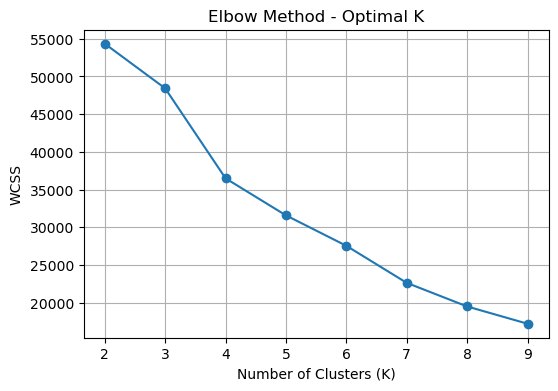

In [8]:
wcss = []
K_range = range(2, 10)

for k in K_range:
    km = KMeans(n_clusters=k, init="k-means++", random_state=42)
    km.fit(X_cluster)
    wcss.append(km.inertia_)   # inertia_ = WCSS

plt.figure(figsize=(6,4))
plt.plot(K_range, wcss, marker='o')
plt.title("Elbow Method - Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()


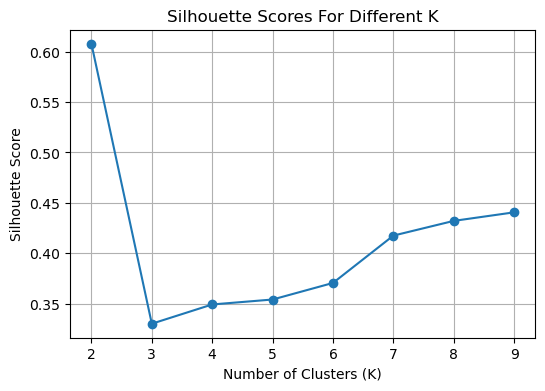

In [9]:
#Silhouette Score Method
#Used Silhouette Score to confirm best K
silhouette_scores = []

for k in range(2, 10):
    km = KMeans(n_clusters=k, init="k-means++", random_state=42)
    labels = km.fit_predict(X_cluster)
    score = silhouette_score(X_cluster, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(6,4))
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title("Silhouette Scores For Different K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


In [18]:
#DBI index
dbi_scores = []

K_range = range(2, 10)  # Check for K = 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42)
    labels = kmeans.fit_predict(X_cluster)

    # Calculate DBI for this K
    dbi = davies_bouldin_score(X_cluster, labels)
    dbi_scores.append(dbi)

    print(f"K = {k} → DBI = {dbi:.4f}")
print("\nBest K based on lowest DBI:", K_range[np.argmin(dbi_scores)])

K = 2 → DBI = 1.1771
K = 3 → DBI = 1.5093
K = 4 → DBI = 1.2227
K = 5 → DBI = 1.2018
K = 6 → DBI = 1.1578
K = 7 → DBI = 0.9423
K = 8 → DBI = 0.9490
K = 9 → DBI = 0.9385

Best K based on lowest DBI: 9


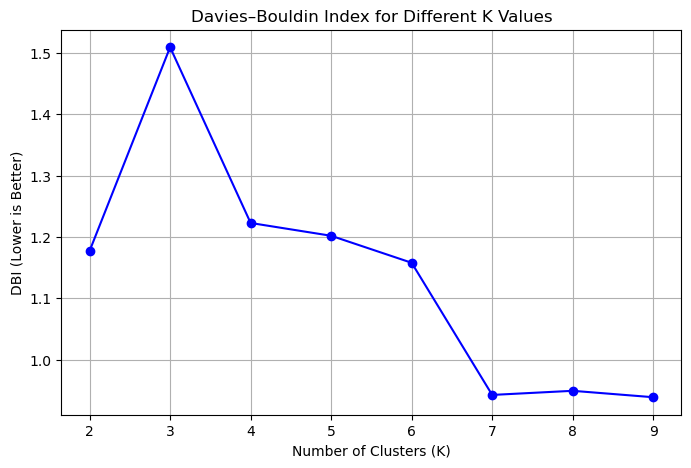

In [20]:
plt.figure(figsize=(8,5))
plt.plot(list(K_range), dbi_scores, marker='o', linestyle='-', color='blue')
plt.title("Davies–Bouldin Index for Different K Values")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("DBI (Lower is Better)")
plt.grid(True)
plt.show()

In [39]:
best_k = 4

kmeans_final = KMeans(n_clusters=best_k, init="k-means++", random_state=42)
df["cluster"] = kmeans_final.fit_predict(X_cluster)

print("Clustering completed!")
df["cluster"].value_counts()

Clustering completed!


cluster
0    5228
1    3607
3     666
2     499
Name: count, dtype: int64

In [33]:
#Analyse Each Cluster
cluster_summary = df.groupby("cluster")[cluster_features].mean()
cluster_summary


,max_power_kw,avg_power_per_connector,has_fast_charger,stations_per_borough,borough_density_km2,latitude,longitude,uk_avg_util_pct,priority_score
cluster,,,,,,,,,
0,4.488925,4.488925,0.000000,7733.202181,9257.982829,51.496921,-0.204477,50.216667,0.127956
1,4.853673,4.853673,0.000000,5407.875520,9263.498666,51.492551,-0.079005,50.216667,0.128569
2,16.684770,16.684770,0.480962,207.090180,15178.320441,51.521651,-0.137831,50.216667,0.251036
3,37.429429,37.429429,1.000000,5639.309309,9249.203222,51.529589,-0.145431,50.216667,0.161679


In [35]:
output_path = "uk_stations_clustered.csv"
df.to_csv(output_path, index=False)

print("Clustered dataset saved at:", output_path)


Clustered dataset saved at: uk_stations_clustered.csv


In [37]:
df.head(10)

,operator,status,is_operational,latitude,longitude,num_points,connector_types,max_power_kw,borough,borough_density_km2,...,stations_per_borough,operational_flag,usage_Private - Restricted Access,usage_Privately Owned - Notice Required,usage_Public,usage_Public - Membership Required,usage_Public - Pay At Location,avg_power_per_connector,has_fast_charger,cluster
0,Ev Dot,Not Operational,False,51.507351,-0.127758,1.0,Type 2 (Socket Only); Type 2 (Socket Only),7.0,Outer London,9318.948649,...,7950,0,False,False,False,False,True,7.0,0,0
1,Independent Operator,Operational,True,51.507291,-0.128896,1.0,0,4.8,Westminster,13608.400000,...,476,1,False,False,True,False,False,4.8,0,2
2,Bp Pulse (Uk),Operational,True,51.507099,-0.130117,8.0,BS1363 3 Pin 13 Amp; Type 2 (Socket Only),7.0,Westminster,13608.400000,...,476,1,False,False,False,True,False,7.0,0,2
3,Virta,Operational,True,51.508903,-0.125534,1.0,Type 2 (Socket Only),7.0,Westminster,9318.948649,...,476,1,False,False,False,False,False,7.0,0,1
4,Bp Pulse (Uk),Operational,True,51.509162,-0.130650,4.0,Type 2 (Socket Only),4.0,Westminster,13608.400000,...,476,1,False,False,False,True,False,4.0,0,2
5,Pod Point (Uk),Operational,True,51.506477,-0.123770,2.0,Type 2 (Socket Only),7.0,Westminster,13608.400000,...,476,1,False,False,False,True,False,7.0,0,2
6,Bp Pulse (Uk),Operational,True,51.510475,-0.126729,2.0,CCS (Type 2); CHAdeMO; Type 2 (Tethered Connec...,50.0,Westminster,9318.948649,...,476,1,False,False,False,True,False,50.0,1,3
7,Shell Recharge Solutions (Uk),Not Operational,False,51.510492,-0.125554,1.0,Type 2 (Socket Only),5.0,Westminster,9318.948649,...,476,0,False,False,False,False,True,5.0,0,1
8,Pod Point (Uk),Operational,True,51.506042,-0.133653,4.0,Type 2 (Socket Only),7.0,Westminster,9318.948649,...,476,1,False,False,False,False,False,7.0,0,1
9,Bp Pulse (Uk),Operational,True,51.507729,-0.134570,2.0,Type 2 (Socket Only),7.0,Westminster,13608.400000,...,476,1,False,False,False,True,False,7.0,0,2
